# Tense and Slow 2022 Standard Bank Lab Hackathon Solution


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pandas.io.formats import style
from sklearn.model_selection import cross_val_score
from dateutil import easter as est
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# Integral control system used to adjust model prediction errors from the test case values.

class integControl:
    def __init__(self, dayWeights = [1,1,1,1,1,1,1], dayErrs = [0,0,0,0,0,0,0]):
        self.dayIntegrator = dayWeights.copy();
        self.dayPrevStepErr = dayErrs.copy();
    
    def runControl(self, data:pd.DataFrame, gain=0.05):
        newPreds = [];
        for i,row in data.iterrows():
            day = int(row["DoW"])
            self.dayIntegrator[day] -= self.dayPrevStepErr[day]*gain
            newPred = self.dayIntegrator[day]*row["pred"]
            if(row["Quantity"] != 0):
                self.dayPrevStepErr[day]  = (newPred - row["Quantity"])/row["Quantity"]
            else:
                self.dayPrevStepErr[day]  = 0
            if(self.dayPrevStepErr[day]>3): self.dayPrevStepErr[day] = 0
            newPreds.append(newPred)
        return newPreds
    
    def updatePred(self, data:pd.DataFrame):
        newPreds = [];
        for i,row in data.iterrows():
            day = int(row["DoW"])
            newPreds.append(self.dayIntegrator[day]*row["pred"])
        return newPreds

In [3]:
# Restaurant raw data
rest1dat = pd.read_csv("restaurant-1-orders.csv")
rest1price = pd.read_csv("restaurant-1-products-price.csv")

rest2dat = pd.read_csv("restaurant-2-orders.csv")
rest2price = pd.read_csv("restaurant-2-products-price.csv")

# London Weather Raw Data
weatherdat = pd.read_csv("london_weather.csv")
weatherdat.columns

# UK Holidays
ukholidat = pd.read_excel("UK Holidays.xlsx")

# Indian Holidays
indholidat = pd.read_csv("indian_holidays.csv")


In [4]:
# Aggregating weather data. See: https://www.kaggle.com/code/mellisawood/weatherprediction

# Setting date formats
weatherdat = weatherdat.dropna(axis=0)
weatherdat['date'] = pd.to_datetime(weatherdat['date'], format = '%Y%m%d')

rest1dat['Order Date'] = pd.to_datetime(rest1dat['Order Date'], dayfirst = True)
rest2dat['Order Date'] = pd.to_datetime(rest2dat['Order Date'], dayfirst = True)

rest1dat.rename(columns={'Order Date':'date'}, inplace=True)
rest2dat.rename(columns={'Order Date':'date'}, inplace=True)

ukholidat['date'] = pd.to_datetime(ukholidat['date'], dayfirst = True).dt.date
indholidat['offdate'] = pd.to_datetime(indholidat['offdate'], dayfirst = True).dt.date

# Creating data sets for quantity analysis See: https://www.kaggle.com/code/malhardata/sales-forecasting-model

rest1grouped = rest1dat[['date', 'Quantity']].resample('D', on='date').sum().reset_index()
rest2grouped = rest2dat[['date', 'Quantity']].resample('D', on='date').sum().reset_index()

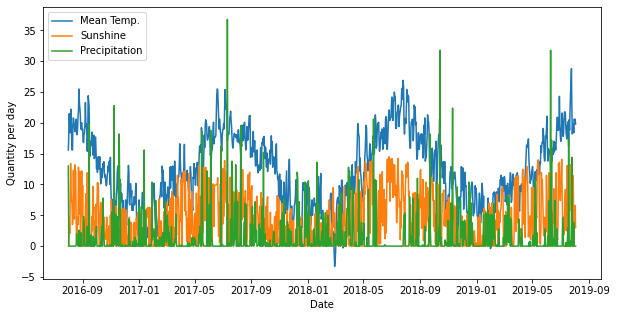

In [31]:
#Showing weather data of mean_temp, sunshine and precipitation.
plt.figure(figsize = (10,5))
sns.lineplot(data = weatherdat, x = 'date', y = 'mean_temp',label='Mean Temp.')
sns.lineplot(data = weatherdat, x = 'date', y = 'sunshine',label='Sunshine')
sns.lineplot(data = weatherdat, x = 'date', y = 'precipitation',label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Quantity per day')
plt.legend()
plt.savefig("weatherdat.jpg", dpi=300)
plt.show()

In [6]:
# construct indian holidays dataframe
Ihol2019 = indholidat.copy()
for index, row in Ihol2019.iterrows():
    if row["offdate"].year!=2019:
        Ihol2019.drop(index, inplace=True)
Ihol2019.rename(columns = {'offdate':'date', 'event':'holiday'}, inplace = True)

# construct uk holidays dataframe
Uhol2019 = ukholidat.copy()
Uhol2019.drop(['countryOrRegion','holidayName','isPaidTimeOff','countryRegionCode'], inplace=True, axis=1)
for index, row in Uhol2019.iterrows():
    if row["date"].year!=2019:
        Uhol2019.drop(index, inplace=True)
Uhol2019.rename(columns = {'normalizeHolidayName':'holiday'}, inplace = True)
columns_titles = ['date','holiday']
Uhol2019=Uhol2019.reindex(columns=columns_titles)

hol2019=pd.concat([Ihol2019,Uhol2019])
hol2019['MoY'] = [x.month for x in hol2019.date]
hol2019['DoM'] = [x.day for x in hol2019.date]
hol2019['DoW'] = [x.weekday() for x in hol2019.date]
hol2019.sort_values(['MoY', 'DoM'], ascending = [True, True],inplace=True)
hol2019.drop([33,50,164,165], inplace=True) #remove duplicates and easter
hol2019.reset_index(drop=True, inplace=True)
hol2019.drop([0], inplace=True) #removes new years duplicate
# print(hol2019)
hol2019.reset_index(inplace=True)
hol2019.rename(columns = {'index':'hId'}, inplace = True)
hol2019.drop(["date", "holiday"], inplace=True, axis=1)

In [7]:
# function to construct dataframe for all days in a given range
def create_date_table(start='2000-01-01', end='2050-12-31'):
    start_ts = pd.to_datetime(start).date()
    end_ts = pd.to_datetime(end).date()
    dates = pd.date_range(start_ts, end_ts)
    df =  pd.DataFrame(index=range(dates.size))
    hIDarr = []
    for date in dates:
        hIDarr.append(ret_hID(date.year,date.month,date.day,date.dayofweek))
    
    df['DoM'] = dates.day
    df['MoY'] = dates.month
    df['DoW'] = dates.dayofweek
    df["hID"] = hIDarr
    
    return df

def ret_hID(year, month, monthDay, weekDay):
    day = 0
    for index, row in hol2019.iterrows():
        if(row["MoY"]==month and row["DoM"]==monthDay):
            day = row["hId"]
    estrWknd = [est.easter(year) - timedelta(days=2),est.easter(year) - timedelta(days=1),est.easter(year),est.easter(year) + timedelta(days=1)]
    for i, estr in enumerate(estrWknd):
        if(estr.month==month and estr.day==monthDay):
            day = len(hol2019.index)+1+i
    return day
                

catDat = create_date_table('2016-08-07', end='2019-08-03')

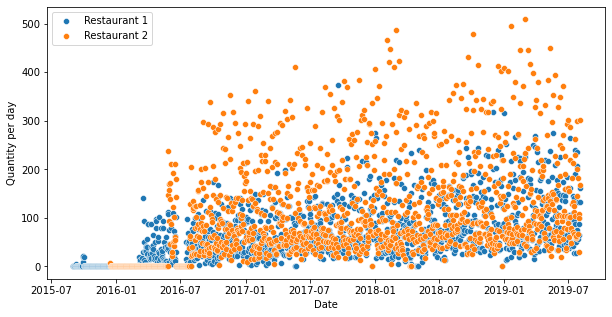

In [8]:
# Visualise the quantity size data as a function of time to select best data set 

plt.figure(figsize = (10,5))
sns.scatterplot(x = rest1grouped['date'], y = rest1grouped['Quantity'], label = 'Restaurant 1')
sns.scatterplot(x = rest2grouped['date'], y = rest2grouped['Quantity'],label='Restaurant 2')
plt.xlabel('Date')
plt.ylabel('Quantity per day')
plt.savefig("rest1quantall.jpg", dpi=300)
plt.legend()
plt.show()


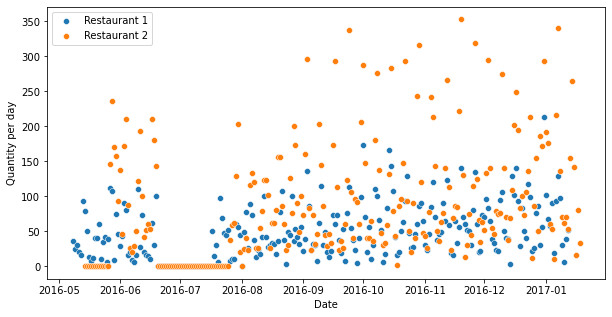

In [9]:
# Zooming in to see the precise data time to select the best quality data.
plt.figure(figsize = (10,5))
sns.scatterplot(x = rest1grouped['date'].iloc[250:500], y = rest1grouped['Quantity'].iloc[250:500], label = 'Restaurant 1')
sns.scatterplot(x = rest2grouped['date'].iloc[150:400], y = rest2grouped['Quantity'].iloc[150:400],label='Restaurant 2')
plt.xlabel('Date')
plt.ylabel('Quantity per day')
plt.savefig("rest1quantallzoom.jpg", dpi=300)
plt.legend()
plt.show()

In [10]:
# Conclusion is data with best quality is above 2016-08-01

rest1dat = rest1dat.loc[rest1dat['date'] >='2016-08-01' ].sort_values(by = 'date',ascending= True)
rest2dat = rest2dat.loc[rest2dat['date'] >='2016-08-01' ].sort_values(by = 'date',ascending= True)

weatherdat = weatherdat.loc[weatherdat['date'] >='2016-08-01']
weatherdat = weatherdat.loc[weatherdat['date'] <= '2019-08-03']

In [11]:
# Price per unit quantity: Can be use for estimating revenue and can be used to scale quantity solution.

restTempData = rest1dat.copy()
restTempData["TotRev"] = rest1dat["Quantity"]*rest1dat["Product Price"]
rev = restTempData["TotRev"].sum()/restTempData["Quantity"].sum()

restTempData2 = rest2dat.copy()
restTempData2["TotRev"] = rest2dat["Quantity"]*rest2dat["Product Price"]
rev2 = restTempData2["TotRev"].sum()/restTempData2["Quantity"].sum()
print(rev,rev2)

4.800774562683041 4.617246211548767


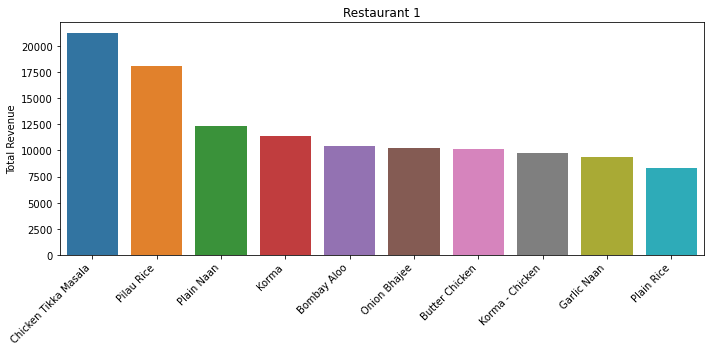

In [12]:
# Investigating top item trends: Restaurant 1
plt.figure(figsize = (10,5))
poprest1 = restTempData.groupby([pd.Grouper(key = 'Item Name')])['TotRev'].sum().reset_index().sort_values('TotRev',ascending=False)
sns.barplot(data=poprest1[:10],x = 'Item Name', y='TotRev')
plt.title('Restaurant 1')
plt.xlabel('')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45,horizontalalignment='right')
plt.savefig("rest1topitem.jpg", dpi=300, bbox_inches = "tight")
plt.tight_layout()
plt.show()

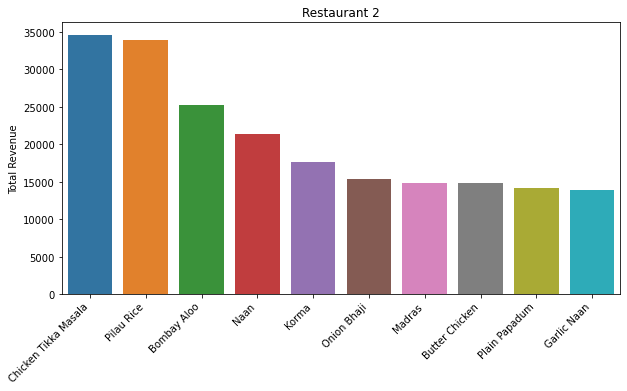

In [13]:
# Investigating top item trends: Restaurant 2
plt.figure(figsize = (10,5))
poprest1 = restTempData2.groupby([pd.Grouper(key = 'Item Name')])['TotRev'].sum().reset_index().sort_values('TotRev',ascending=False)
sns.barplot(data=poprest1[:10],x = 'Item Name', y='TotRev')
plt.title('Restaurant 2')
plt.xlabel('')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45,horizontalalignment='right')
plt.savefig("rest2topitem.jpg", dpi=300, bbox_inches = "tight")
plt.show()

In [14]:
# Pick top 2 items from each restaurant in product price (heuristic: intersection with non-condiment volume, highest possible gains).
# Check: Correlation matrix

dfr1 = rest1dat[['date','Quantity']]
dfr1tkm = rest1dat[rest1dat['Item Name'] == 'Chicken Tikka Masala']
dfr1pr =rest1dat[rest1dat['Item Name'] == 'Pilau Rice']


# Order by Date and sum quantities on each day

dfr1 = dfr1.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')
dfr1tkm = dfr1tkm.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')
dfr1pr = dfr1pr.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')


# Date - Month - Year
dfr1['DoW'] = dfr1['date'].dt.dayofweek
dfr1['DoM'] = dfr1['date'].dt.day
dfr1['MoY'] = dfr1['date'].dt.month

dfr1tkm['DoW'] = dfr1tkm['date'].dt.dayofweek
dfr1tkm['DoM'] = dfr1tkm['date'].dt.day
dfr1tkm['MoY'] = dfr1tkm['date'].dt.month

dfr1pr['DoW'] = dfr1pr['date'].dt.dayofweek
dfr1pr['DoM'] = dfr1pr['date'].dt.day
dfr1pr['MoY'] = dfr1pr['date'].dt.month


# Feature engineering based on on std metric of Chicken Tikka Masala - https://www.kaggle.com/code/malhardata/sales-forecasting-model
# Up to 3 standard deviations ahead in the future prediciton.

for i in range (1,6):
    label = "Quantity_" + str(i)
    dfr1[label] = dfr1['Quantity'].shift(i)
    dfr1tkm[label] = dfr1tkm['Quantity'].shift(i)
    dfr1pr[label] = dfr1pr['Quantity'].shift(i)
    label = "Average_" + str(i)
    dfr1tkm[label] = dfr1tkm['Quantity'].rolling(i).mean().shift(1)
    dfr1pr[label] = dfr1pr['Quantity'].rolling(i).mean().shift(1)

dfr1 = dfr1.dropna()
dfr1tkm = dfr1tkm.dropna()
dfr1pr = dfr1pr.dropna()


In [15]:
# Pick top 2 items from each restaurant in product price (heuristic: intersection, highest possible gains).
# Check: Confusion matrix

dfr2 = rest2dat[['date','Quantity']]
dfr2tkm = rest2dat[rest2dat['Item Name'] == 'Chicken Tikka Masala']
dfr2pr =rest2dat[rest2dat['Item Name'] == 'Pilau Rice']


# Order by Date and quantity

dfr2 = dfr2.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')
dfr2tkm = dfr2tkm.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')
dfr2pr = dfr2pr.groupby([pd.Grouper(key='date', freq='D')])['Quantity'].sum().reset_index().sort_values('date')


# Day of Week - Day of Month - Month of Year

dfr2['DoW'] = dfr2['date'].dt.dayofweek
dfr2['DoM'] = dfr2['date'].dt.day
dfr2['MoY'] = dfr2['date'].dt.month

dfr2tkm['DoW'] = dfr2tkm['date'].dt.dayofweek
dfr2tkm['DoM'] = dfr2tkm['date'].dt.day
dfr2tkm['MoY'] = dfr2tkm['date'].dt.month

dfr2pr['DoW'] = dfr2pr['date'].dt.dayofweek
dfr2pr['DoM'] = dfr2pr['date'].dt.day
dfr2pr['MoY'] = dfr2pr['date'].dt.month


# Feature engineering based on shifts of order volume - https://www.kaggle.com/code/malhardata/sales-forecasting-model


for i in range (1,6):
    label = "Quantity_" + str(i)
    dfr2[label] = dfr2['Quantity'].shift(i)
    dfr2tkm[label] = dfr2tkm['Quantity'].shift(i)
    dfr2pr[label] = dfr2pr['Quantity'].shift(i)
    label = "Average_" + str(i)
    dfr2tkm[label] = dfr2tkm['Quantity'].rolling(i).mean().shift(1)
    dfr2pr[label] = dfr2pr['Quantity'].rolling(i).mean().shift(1)

dfr2 = dfr2.dropna()
dfr2tkm = dfr2tkm.dropna()
dfr2pr = dfr2pr.dropna()

In [16]:
# Concatenate the data set to weather data 

dfr1 = pd.merge(dfr1,weatherdat,on='date',how='outer').dropna()
dfr1tkm = pd.merge(dfr1tkm,weatherdat,on='date',how='outer').dropna()
dfr1pr = pd.merge(dfr1pr,weatherdat,on='date',how='outer').dropna()

dfr2 = pd.merge(dfr2,weatherdat,on='date',how='outer').dropna()
dfr2tkm = pd.merge(dfr2tkm,weatherdat,on='date',how='outer').dropna()
dfr2pr = pd.merge(dfr2pr,weatherdat,on='date',how='outer').dropna()

In [17]:
# Concatenate data+weather to holidays

dfr1 = pd.merge(dfr1,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()
dfr1tkm = pd.merge(dfr1tkm,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()
dfr1pr = pd.merge(dfr1pr,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()

dfr2 = pd.merge(dfr2,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()
dfr2tkm = pd.merge(dfr2tkm,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()
dfr2pr = pd.merge(dfr2pr,create_date_table('2016-08-07', end='2019-08-03'), on = ['DoW','DoM','MoY'], how ='outer').dropna()

In [18]:
# Convert Dates to Int for train_test_split

dfr1['date'] = pd.to_datetime(dfr1['date']).dt.strftime("%Y%m%d").astype(int)
dfr1tkm['date'] = pd.to_datetime(dfr1tkm['date']).dt.strftime("%Y%m%d").astype(int)
dfr1pr['date'] = pd.to_datetime(dfr1pr['date']).dt.strftime("%Y%m%d").astype(int)

dfr2['date'] = pd.to_datetime(dfr2['date']).dt.strftime("%Y%m%d").astype(int)
dfr2tkm['date'] = pd.to_datetime(dfr2tkm['date']).dt.strftime("%Y%m%d").astype(int)
dfr2pr['date'] = pd.to_datetime(dfr2pr['date']).dt.strftime("%Y%m%d").astype(int)

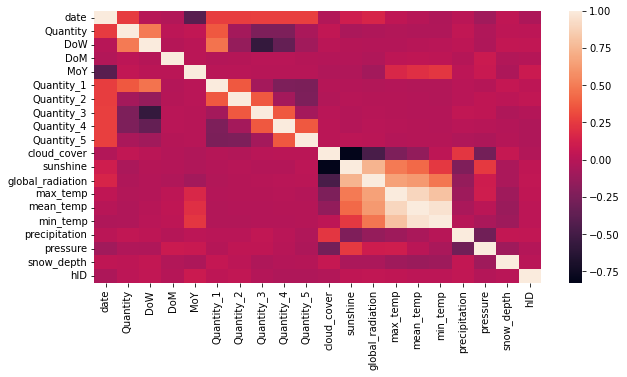

In [19]:
# Use correlation matrix to investigate elements. Convert to executable by using Esc+Y

def corr_mat(x):
    plt.figure(figsize = (10,5))
    corrMatrix = x.corr()
    sns.heatmap(corrMatrix, annot=False)
    plt.savefig("corrmat.jpg", dpi=300, bbox_inches = "tight")
    plt.show()
corr_mat(dfr1)

In [20]:
# Defining output vectors

dfr1y = dfr1['Quantity']
dfr1tkmy = dfr1tkm['Quantity']
dfr1pry = dfr1pr['Quantity']

dfr2y = dfr2['Quantity']
dfr2tkmy = dfr2tkm['Quantity']
dfr2pry = dfr2pr['Quantity']

In [23]:
# Test and training for all the data sets of interest Restaurant 1 and 2, and Chicken Tikka Masala Orders and Pilau Rice

X_traindate = [dfr1[:800],dfr1tkm[:800],dfr1pr[:800],dfr2[:800],dfr2tkm[:800],dfr2pr[:800]]
X_train = [x.drop(['date'],axis=1).drop(['Quantity'],axis=1) for x in X_traindate] # list comprehension for preparing training data

X_testdate = [dfr1[800:],dfr1tkm[800:],dfr1pr[800:],dfr2[800:],dfr2tkm[800:],dfr2pr[800:]]
X_test = [x.drop(['date'],axis=1).drop(['Quantity'],axis=1) for x in X_testdate]

y_train = [dfr1y[:800],dfr1tkmy[:800],dfr1pry[:800],dfr2y[:800],dfr2tkmy[:800],dfr2pry[:800]]
y_test = [dfr1y[800:],dfr1tkmy[800:],dfr1pry[800:],dfr2y[800:],dfr2tkmy[800:],dfr2pry[800:]]

In [24]:
# Making model lists for restaurants 1 and 2 and food items: Chicken Tikka Masala (8.95) & Pilau Rice (2.95)

modellist = []
modeldata = []

for i in range(6):
    quant_model = XGBRegressor(n_estimators=500,learning_rate=0.11)
    val_set = [(X_train[i],y_train[i])]
    fit = quant_model.fit(X_train[i], y_train[i],eval_set=val_set,verbose=False)
    modellist.append(fit)
    modeldata.append(fit.predict(X_test[i]))
    

In [25]:
modellist[0].score(X_train[0],y_train[0])

0.9999976027261626

In [26]:
# Creating output lists for converting date formats and compiling model predictions
pred_setlist = []
for i in range(6):
    pred = pd.Series(modeldata[i])
    pred_set = X_testdate[i].reset_index(drop=True)
    pred_set['pred'] = pred
    pred_set = pred_set.sort_values(by ='date',ascending= True)
    pred_set['date'] = pd.to_datetime(pred_set['date'].astype(str), format='%Y%m%d')
    pred_set = pred_set.groupby([pd.Grouper(key='date', freq='D')])[['Quantity','pred']].mean().reset_index().sort_values('date')
    pred_setlist.append(pred_set)

In [29]:
# Plot function: takes in an array of data with three columns arr_x and the price of the item to get the revenue curve
def plot(arr_x,price):
    plt.figure(figsize = (10,6))
    sns.lineplot(x=arr_x['date'],y=arr_x['pred']*price,label='Model Prediction',lw=3)
    sns.lineplot(x=arr_x['date'],y=arr_x['Quantity']*price,label='Test Set')
#     plt.xlim(pd.Timestamp('2018-12-21'), pd.Timestamp('2018-12-28'))
    plt.xlabel('Date')
    plt.ylabel('Weekly Order Quantity per day')
    plt.legend()
    plt.savefig("weekpred.jpg", dpi=300, bbox_inches = "tight")
    plt.show()

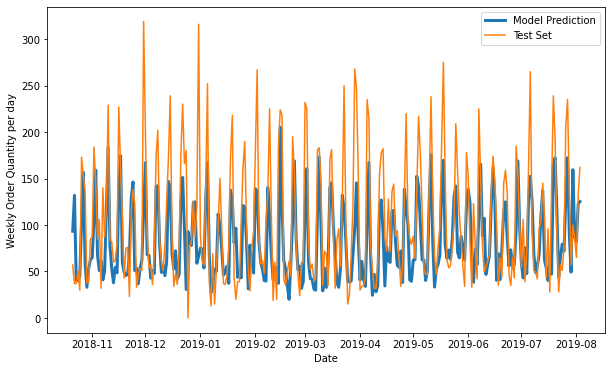

In [30]:
plot(pred_setlist[0],1)
